# FEgrow: An Open-Source Molecular Builder and Free Energy Preparation Workflow

**Authors: Mateusz K Bieniek, Ben Cree, Rachael Pirie, Joshua T. Horton, Natalie J. Tatum, Daniel J. Cole**

* Add chemical functional groups (R-groups) in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Output structures for free energy calculations

## Overview

This notebook demonstrates the entire `FEgrow` workflow for generating a series of ligands with a common core for a specific binding site, via the addition of a user-defined set of R-groups. 

These *de novo* ligands are then subjected to ADMET analysis. Valid conformers of the added R-groups are enumerated, and optimised in the context of the receptor binding pocket, optionally using hybrid machine learning / molecular mechanics potentials (ML/MM).

An ensemble of low energy conformers is generated for each ligand, and scored using the `gnina` convolutional neural network (CNN). Output structures are saved as `pdb` files ready for use in free energy calculations.

The target for this tutorial is the main protease (Mpro) of SARS-CoV-2, and the core and receptor structures are taken from a [recent study by Jorgensen & co-workers](https://doi.org/10.1021/acscentsci.1c00039).

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


In [2]:
#!git clone https://github.com/cole-group/FEgrow.git

fatal: destination path 'FEgrow' already exists and is not an empty directory.


In [ ]:
!conda install -c conda-forge rdkit prody

In [5]:
!conda install -c conda-forge openff-toolkit-base -y

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.



In [ ]:
!conda install -c conda-forge parmed -y

In [ ]:
!!conda install -c conda-forge openmmforcefields -y

In [6]:
!conda install -c conda-forge typing-extensions -y

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.



In [ ]:
!conda install -c conda-forge pdbfixer -y

In [ ]:
!conda install -c conda-forge typing tqdm openbabel -y

In [ ]:
!conda install -c conda-forge torchani pytorch openmm pint -y

In [ ]:
!pip install py3dmol mols2grid 

In [12]:
!git clone https://github.com/cole-group/FEgrow.git

Cloning into 'FEgrow'...
remote: Enumerating objects: 4194, done.
remote: Counting objects: 100% (4194/4194), done.
remote: Compressing objects: 100% (1120/1120), done.
remote: Total 4194 (delta 3032), reused 4146 (delta 3009), pack-reused 0
Receiving objects: 100% (4194/4194), 16.00 MiB | 23.58 MiB/s, done.
Resolving deltas: 100% (3032/3032), done.


In [14]:
%cd FEgrow

/content/FEgrow


In [ ]:
!pip install .

In [17]:
!python -m ipykernel install --user --name=fegrow

Installed kernelspec fegrow in /root/.local/share/jupyter/kernels/fegrow


In [15]:
!python setup.cfg

  File "setup.cfg", line 3
    version = file: fegrow/version.txt
                  ^
SyntaxError: invalid syntax


In [18]:
import copy

import prody
from rdkit import Chem

import fegrow
from fegrow import RGroups

MolGridWidget()

# Prepare the ligand template

The provided core structure `lig.pdb` has been extracted from a crystal structure of Mpro in complex with compound **4** from the Jorgensen study (PDB: 7L10), and a Cl atom has been removed to allow growth into the S3/S4 pocket. The template structure of the ligand is protonated with [Open Babel](http://openbabel.org/wiki/Main_Page):

In [21]:
%cd notebooks

/content/FEgrow/notebooks


In [22]:
!obabel sarscov2/lig.pdb -O sarscov2/coreh.sdf -p 7

1 molecule converted


Load the protonated ligand into FEgrow:

In [23]:
init_mol = Chem.SDMolSupplier('sarscov2/coreh.sdf', removeHs=False)[0]

# get the FEgrow representation of the rdkit Mol
template_mol = fegrow.RMol(init_mol)

Show the 2D (with indices) representation of the core. This is used to select the desired growth vector.

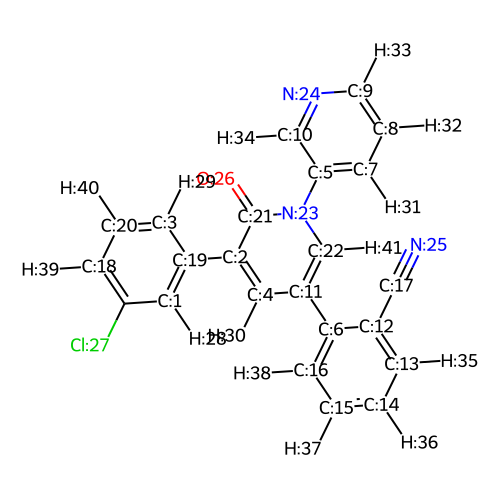

In [24]:
template_mol.rep2D(idx=True, size=(500, 500))

Using the 2D drawing, select an index for the growth vector. Note that it is currently only possible to grow from hydrogen atom positions. In this case, we are selecting the hydrogen atom labelled H:40 to enable growth into the S3/S4 pocket of Mpro.

In [25]:
attachment_index = [40]

R-groups can be selected interactively or programmaticaly.

We have provided a set of common R-groups (see `fegrow/data/rgroups/library`), which can be browsed and selected interactively below.

Molecules from the library can alternatively be selected by name, as demonstrated below.

Finally, user-defined R-groups may be provided as `.mol` files. *In this case, the hydrogen atom selected for attachment should be replaced by the element symbol R.* See the directory `manual_rgroups` for examples.

In [26]:
# interactive selection
RGroups

In [27]:
# retrieve the interactively selected groups
interactive_rgroups = RGroups.get_selected()

# you can also directly access the built-in dataframe programmatically
groups = RGroups.dataframe
R_group_ethanol = groups.loc[groups['Name']=='*CCO']['Mol'].values[0]
R_group_cyclopropane = groups.loc[groups['Name'] == '*C1CC1' ]['Mol'].values[0]

# add your own R-groups files
R_group_propanol = Chem.MolFromMolFile('manual_rgroups/propan-1-ol-r.mol', removeHs=False)

# make a list of R-group molecule
selected_rgroups = [R_group_propanol, R_group_ethanol, R_group_cyclopropane] + interactive_rgroups
selected_rgroups

# Build a congeneric series

Now that the R-groups have been selected, we merge them with the ligand core:

In [28]:
rmols = fegrow.build_molecules(template_mol, 
                               attachment_index, 
                               selected_rgroups)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7fc8f58338e0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7fc8f5833820>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7fc8f5890d00> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7fc8f5833820>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7fc8f5773580> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7fc8f5833b20>


In [29]:
rmols

,Smiles,Molecule
ID,,
0,[H]c1nc([H])c(-n2c([H])c(-c3c([H])c([H])c([H])...,<rdkit.Chem.rdchem.Mol object at 0x7fc8f572ca00>
1,[H]OC([H])([H])C([H])([H])c1c([H])c(Cl)c([H])c...,<rdkit.Chem.rdchem.Mol object at 0x7fc8f572cc40>
2,[H]c1nc([H])c(-n2c([H])c(-c3c([H])c([H])c([H])...,<rdkit.Chem.rdchem.Mol object at 0x7fc8f5748280>


The R-group library can also be viewed as a 2D grid, or individual molecules can be selected for 3D view (note that the conformation of the R-group has not yet been optimised):

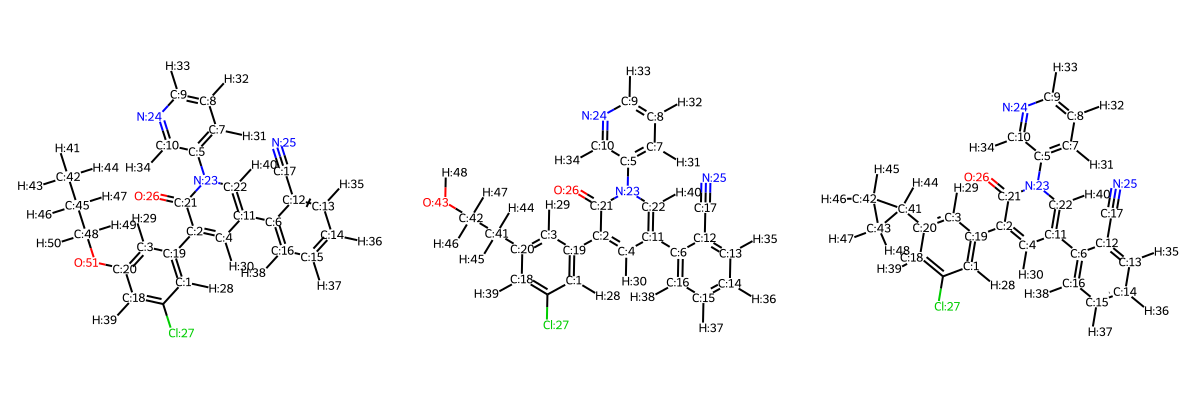

In [30]:
rmols.rep2D()

In [33]:
rmols[2].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Once the ligands have been generated, they can be assessed for various ADMET properties, including Lipinksi rule of 5 properties, the presence of unwanted substructures or problematic functional groups, and synthetic accessibility.

In [34]:
rmols.toxicity()

,MW,HBA,HBD,LogP,Pass_Ro5,has_pains,has_unwanted_subs,has_prob_fgs,synthetic_accessibility,Smiles,Molecule
ID,,,,,,,,,,,
0,441.918,5,0,5.880,True,False,False,True,7.634562,[H]c1nc([H])c(-n2c([H])c(-c3c([H])c([H])c([H])...,<rdkit.Chem.rdchem.Mol object at 0x7fc8f5773f40>
1,427.891,5,1,4.626,True,False,False,True,7.501563,[H]OC([H])([H])C([H])([H])c1c([H])c(Cl)c([H])c...,<rdkit.Chem.rdchem.Mol object at 0x7fc8f56ea1c0>
2,423.903,4,0,5.969,True,False,False,True,7.482970,[H]c1nc([H])c(-n2c([H])c(-c3c([H])c([H])c([H])...,<rdkit.Chem.rdchem.Mol object at 0x7fc8f56ea460>


For each ligand, a specified number of conformers (`num_conf`) is generated by using the RDKit [ETKDG algorithm](https://doi.org/10.1021/acs.jcim.5b00654). Conformers that are too similar to an existing structure are discarded. Empirically, we have found that `num_conf=200` gives an exhaustive search, and `num_conf=50` gives a reasonable, fast search, in most cases.

If required, a third argument can be added `flexible=[0,1,...]`, which provides a list of additional atoms in the core that are allowed to be flexible. This is useful, for example, if growing from a methyl group and you would like the added R-group to freely rotate.

In [35]:
rmols.generate_conformers(num_conf=50, 
                          minimum_conf_rms=0.5, 
                          # flexible=[3, 18, 20])
                        )

RMol index 0
Removed 26 duplicated conformations, leaving 25 in total. 
RMol index 1
Removed 41 duplicated conformations, leaving 10 in total. 
RMol index 2
Removed 40 duplicated conformations, leaving 11 in total. 


### Prepare the protein

The protein-ligand complex structure is downloaded, and [PDBFixer](https://github.com/openmm/pdbfixer) is used to protonate the protein, and perform other simple repair:

In [36]:
# get the protein-ligand complex structure
!wget -nc https://files.rcsb.org/download/7L10.pdb

# load the complex with the ligand
sys = prody.parsePDB('7L10.pdb')

# remove any unwanted molecules
rec = sys.select('not (nucleic or hetatm or water)')

# save the processed protein
prody.writePDB('rec.pdb', rec)

# fix the receptor file (missing residues, protonation, etc)
fegrow.fix_receptor("rec.pdb", "rec_final.pdb")

# load back into prody
rec_final = prody.parsePDB("rec_final.pdb")

--2023-02-03 22:39:52--  https://files.rcsb.org/download/7L10.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.234
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘7L10.pdb’

7L10.pdb                [  <=>               ] 241.42K  1.10MB/s    in 0.2s    

2023-02-03 22:39:52 (1.10 MB/s) - ‘7L10.pdb’ saved [247212]



@> 2609 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 4638 atoms and 1 coordinate set(s) were parsed in 0.05s.


View enumerated conformers in complex with protein:

In [38]:
rmols[0].rep3D(prody=rec_final)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Any conformers that clash with the protein (any atom-atom distance less than 1 Angstrom), are removed.

In [39]:
rmols.remove_clashing_confs(rec_final)

RMol index 0
Clash with the protein. Removing conformer id: 24
Clash with the protein. Removing conformer id: 20
Clash with the protein. Removing conformer id: 14
Clash with the protein. Removing conformer id: 11
Clash with the protein. Removing conformer id: 8
Clash with the protein. Removing conformer id: 7
Clash with the protein. Removing conformer id: 6
Clash with the protein. Removing conformer id: 5
Clash with the protein. Removing conformer id: 4
Clash with the protein. Removing conformer id: 3
RMol index 1
Clash with the protein. Removing conformer id: 2
Clash with the protein. Removing conformer id: 0
RMol index 2


In [40]:
rmols[0].rep3D(prody=rec_final)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Optimise conformers in context of protein

The remaining conformers are optimised using hybrid machine learning / molecular mechanics (ML/MM), using the [ANI2x](https://doi.org/10.1021/acs.jctc.0c00121) neural nework potential for the ligand energetics (as long as it contains only the atoms H, C, N, O, F, S, Cl). Note that the Open Force Field [Parsley](https://doi.org/10.1021/acs.jctc.1c00571) force field is used for intermolecular interactions with the receptor.

`sigma_scale_factor`: is used to scale the Lennard-Jones radii of the atoms.

`relative_permittivity`: is used to scale the electrostatic interactions with the protein.

`water_model`: can be used to set the force field for any water molecules present in the binding site.

In [51]:
!conda install -c conda-forge openff-toolkit

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.



In [ ]:
#forcefiled changed from openff to gaff

In [55]:
# opt_mol, energies
energies = rmols.optimise_in_receptor(
    receptor_file="rec_final.pdb", 
    ligand_force_field="openff", 
    use_ani=True,
    sigma_scale_factor=0.8,
    relative_permittivity=4,
    water_model = None
)

RMol index 0


missing unary operator "*"


ValueError: ignored

Any of the rmols that have no available conformers (due to unresolvable steric clashes with the protein) can be discarded using the `.discard_missing()` function. This function also returns a list of the indices that were removed, which can be helpful when carrying out data analysis.

In [43]:
missing_ids = rmols.discard_missing()

Optionally, display the final optimised conformers. Note that, unlike classical force fields, ANI allows bond breaking. You may occasionally see ligands with distorted structures and very long bonds, but in our experience these are rarely amongst the low energy structures and can be ignored.

In [42]:
rmols[0].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Conformers are now sorted by energy, only retaining those within 5 kcal/mol of the lowest energy structure:

In [49]:
final_energies = rmols.sort_conformers(energy_range=5)

RMol index 0


AttributeError: ignored

Save all of the lowest energy conformers to files and print the sorted energies in kcal/mol (shifted so that the lowest energy conformer is zero).

In [ ]:
[rmol.to_file(f"best_conformers{i}.pdb") for i, rmol in enumerate(rmols)]

In [ ]:
print(final_energies)

The conformers are scored using the [Gnina](https://github.com/gnina/gnina) molecular docking program and convolutional neural network scoring function. *[Note that this step is not supported on macOS].* If unavailable, the Gnina executable is downloaded during the first time it is used. The CNNscores may also be converted to predicted IC50 (nM) (see column "CNNaffinity->IC50s").

In [ ]:
affinities = rmols.gnina(receptor_file="rec_final.pdb") 
affinities

Predicted binding affinities may be further refined using the structures output by `FEgrow`, using your favourite free energy calculation engine. See our paper for an example using [SOMD](https://github.com/michellab/Sire) to calculate the relative binding free energies of 13 Mpro inhibitors.